In [1]:
import os
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt
import h5py

sys.path.insert(0, "../")

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from architectures.unet import UNet
from architectures.laddernet import LadderNet
from metrics.multiclass_dice import multiclass_dice

In [30]:
print(tf.__version__)

2.0.0


In [2]:
#%load_ext tensorboard

In [2]:
f = h5py.File("../../data/image_dataset.hdf5", "r")

In [3]:
no_train = 158

train_image_subset = f["train 2ch frames"][:no_train,:,:,0]
train_image_subset = train_image_subset.reshape([no_train, 384, 384, 1])

train_mask_subset = f["train 2ch masks"][:no_train,:,:,0]
train_mask_subset = train_mask_subset.reshape([no_train, 384, 384, 1])

In [4]:
train_image_subset.shape

(158, 384, 384, 1)

In [33]:
model_laddernet = LadderNet(input_size=(384,384,1), num_classes=4, filters=10)
model_unet = UNet(input_size=(384,384,1), depth=5, num_classes=4, filters=30, batch_norm=True)

In [20]:
earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5, verbose=1, mode="max", restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2, verbose=1, mode="max", min_lr=1e-5)

In [34]:
model_unet.compile(optimizer=Adam(lr=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice])

In [35]:
history = model_unet.fit(x=train_image_subset,
                         y=train_mask_subset,
                         shuffle=True,
                         batch_size=1,
                         epochs=30)

Train on 158 samples
Epoch 1/30
158/158 [==============================] - 38s 243ms/sample - loss: 0.9013 - multiclass_dice: 0.2284
Epoch 2/30
 64/158 [===========>..................] - ETA: 20s - loss: 0.7431 - multiclass_dice: 0.2723

KeyboardInterrupt: 

In [27]:
plt.rcParams['figure.figsize'] = 10, 6
plt.plot(history.history['multiclass_dice'])
plt.plot(history.history['val_multiclass_dice'])
plt.ylabel('multiclass_dice')
plt.xlabel('epoch')
plt.show()

NameError: name 'history' is not defined

In [22]:
prediction = model_unet.predict(train_image_subset[0:3,:,:,:])

In [23]:
prediction.shape

(3, 384, 384, 4)

In [24]:
import tensorflow as tf

In [25]:
z = tf.math.argmax(prediction, axis = 3)

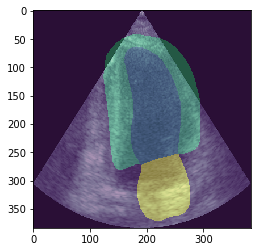

In [36]:
plt.imshow(train_image_subset[0,:,:,0], cmap="bone")
plt.imshow(z[0,:,:], alpha=0.4)

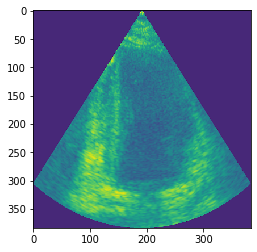

In [37]:
plt.imshow(train_image_subset[0,:,:,0])

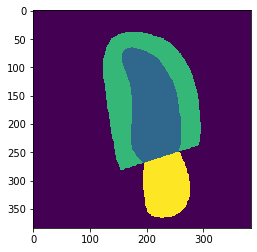

In [38]:
plt.imshow(train_mask_subset[0,:,:,0])

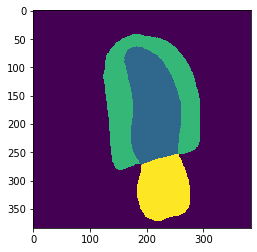

In [29]:
plt.imshow(z[0,:,:],vmin=0, vmax=3)
plt.show()

In [202]:
def get_patches(img_tensor, size=256, stride=128):
    '''
    Takes single image or array of images and returns
    crops using sliding window method.
    If stride < size it will do overlapping.
    '''
    img_arr = np.array(img_tensor)
    type(img_arr)
    img_arr.shape
    # check size and stride
    if size % stride != 0: 
        raise ValueError('size % stride must be equal 0')
        
        
    patches_list = []
    overlapping = 0    
    if stride != size:
        overlapping = (size // stride) - 1
    
    if img_arr.ndim == 3:    
        i_max = img_arr.shape[0] // stride-overlapping

        for i in range(i_max):
            for j in range(i_max):
                #print(i*stride, i*stride+size)
                #print(j*stride, j*stride+size)
                patches_list.append(
                    img_arr[i*stride:i*stride+size,
                            j*stride:j*stride+size
                           ])
                
    elif img_arr.ndim == 4:
        i_max = img_arr.shape[1] // stride - overlapping
        for im in img_arr:
            for i in range(i_max):
                for j in range(i_max):
                    #print(i*stride, i*stride+size)
                    #print(j*stride, j*stride+size)
                    patches_list.append(
                        im[i*stride:i*stride+size,
                           j*stride:j*stride+size
                          ])
                    
    else:
        raise ValueError('img_arr.ndim must be equal 3 or 4')
    
    return np.array(patches_list)

In [29]:
from sklearn.feature_extraction import image
patches = image.extract_patches_2d(z[0,:,:], (128, 128))

In [23]:
z.shape

TensorShape([3, 384, 384])

In [27]:
patches.shape

(103041, 64, 64)

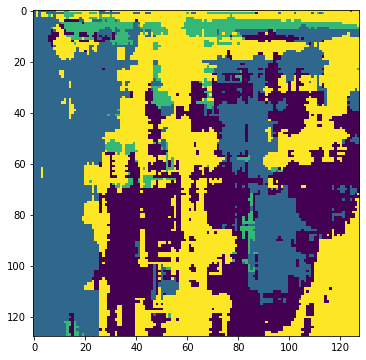

In [30]:
plt.imshow(patches[0,:,:])

In [31]:
reimage = image.reconstruct_from_patches_2d(patches, (384, 384))

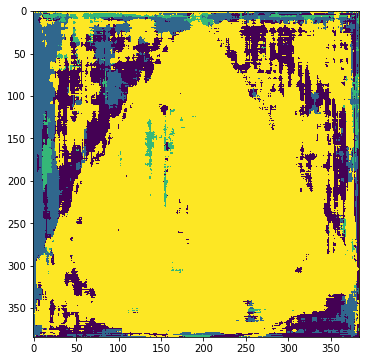

In [33]:
plt.imshow(reimage)

In [34]:
reimage.shape

(384, 384)